In [1]:
from IPython.lib.deepreload import original_import
%load_ext autoreload
%autoreload 2

import ex4
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import shift, gaussian_filter, rotate


#### 1. Align consecutive frames
    a. Lucas Kanade or Point Correspondences, you choose
    b. Create a transformation matrix for every two consecutive frames
    c. Debug: Use synthetic videos: no motion, simple translation,

In [ ]:
import numpy as np
import ex4
from scipy.ndimage import shift, rotate
import matplotlib.pyplot as plt


# --- 1. Create a STRUCTURED image (Sine Wave Grid) ---
# This mimics strong features like buildings or horizons that survive downscaling
def create_grid_image(size=256):
    x = np.linspace(-4 * np.pi, 4 * np.pi, size)
    y = np.linspace(-4 * np.pi, 4 * np.pi, size)
    xv, yv = np.meshgrid(x, y)
    # Create a smooth grid pattern
    im = np.sin(xv) * np.cos(yv)
    # Normalize to 0-1
    return (im - im.min()) / (im.max() - im.min())


im1 = create_grid_image(256)

# --- 2. Define Large Transformation ---
expected_u = 12
expected_v = -8.2
expected_deg = 2.5
expected_theta = np.deg2rad(expected_deg)

print(
    f"Testing Structured Image with: Shift=({expected_u}, {expected_v}), Rot={expected_deg}°")

# --- 3. Apply Transformation ---
# Rotate then Shift
im_rot = rotate(im1, angle=expected_deg, reshape=False, order=3)
im2 = shift(im_rot, shift=[expected_v, expected_u], order=3)

# --- 4. Run Optical Flow (Pyramids) ---
# Using border_cut=11 to capture enough gradient info
u_calc, v_calc, theta_calc = ex4.optical_flow(im1, im2, 16, 11)

# --- 5. Analysis ---
print("\n--- Results ---")
print(f"Trans X: Expected {expected_u:.2f} | Got {u_calc:.4f}")
print(f"Trans Y: Expected {expected_v:.2f} | Got {v_calc:.4f}")
print(
    f"Rot deg: Expected {expected_deg:.2f} | Got {np.rad2deg(theta_calc):.4f}")

err_trans = np.sqrt((u_calc - expected_u) ** 2 + (v_calc - expected_v) ** 2)
err_rot_deg = abs(np.rad2deg(theta_calc) - expected_deg)

print(f"\nErrors -> Trans: {err_trans:.4f} px, Rot: {err_rot_deg:.4f} deg")

if err_trans < 0.5 and err_rot_deg < 0.2:
    print("✅ SUCCESS: Pyramids working on structured image!")
else:
    print("❌ FAIL: Still diverging.")

# Debug Plot: Check if the 'Correction' makes sense
# If the logic is correct, applying the NEGATIVE flow to im2 should make it look like im1
im2_corrected = ex4.warp_image(im2, u_calc, v_calc, theta_calc)

# Note: Depending on your warp definition, you might need to pass (-u, -v, -theta)
# to 'undo' the motion. Let's try to visualize the diff.

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(im1, cmap='gray');
axes[0].set_title('Target (Im1)')
axes[1].imshow(im2, cmap='gray');
axes[1].set_title('Source (Im2)')
# Show difference between Target and Warped Source
axes[2].imshow(np.abs(im1 - im2_corrected), cmap='gray');
axes[2].set_title('Difference')
plt.show()

In [ ]:
im1 = np.zeros((100, 100))
im1[40:60, 40:60] = 1
im2 = np.zeros((100, 100))
u, v = 1, 2
im2[40 + u:60 + u, 40 + v:60 + v] = 1  # Shifted by 1 pixel
print(f"40+u:60+u ={40 + u, 60 + v}, 40+v:60+v ={40 + u, 60 + v}")
# print("diff is: ",abs(40+u - (60+v)))
# 2. Plotting side-by-side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
# Image 1
axes[0].imshow(im1, cmap='gray')
axes[0].set_title("Image 1")
# Image 2
axes[1].imshow(im2, cmap='gray')
axes[1].set_title("Image 2")
# Overlap
axes[2].imshow(im1 + im2, cmap='gray')
axes[2].set_title("Overlap (Visual Debugging)")

# axes.imshow(im1 + im2, cmap='gray')
print(f"Expected shift: u={u}, v={v}")
# plt.show()

In [ ]:
u2, v2, theta = ex4.lucas_kanade_step(im1, im2, 3)
print(f"Calculated shift: u={u2}, v={v2}, theta={theta}")

In [ ]:
# 1. Setup specific shifts
expected_u = 0.1  # Horizontal shift (x)
expected_v = 0.2  # Vertical shift (y)
expected_theta = 0.0  # No rotation for this test

# 2. Create rich texture image (Smoothed Noise)
# Using a slightly larger image helps distinguish rotation from translation
im1 = np.random.rand(150, 150)
im1 = gaussian_filter(im1, sigma=2.0)

# 3. Apply Shift accurately
# Note: scipy shift takes (axis_0_shift, axis_1_shift) -> (v, u)
im2 = shift(im1, shift=[expected_v, expected_u], order=3)
# 4. Run your Rigid LK
u_calc, v_calc, theta_calc = ex4.lucas_kanade_step(im1, im2, border_cut=10)

print(f"Expected: u={expected_u}, v={expected_v}, theta=0")
print(f"Got:      u={u_calc:.4f}, v={v_calc:.4f}, theta={theta_calc:.6f}")

# 5. Analysis
error_trans = np.sqrt((u_calc - expected_u) ** 2 + (v_calc - expected_v) ** 2)
print(f"Translation Error: {error_trans:.4f}")

if error_trans < 0.1 and abs(theta_calc) < 0.01:
    print("✅ SUCCESS: Axis logic and Solver are correct.")
else:
    print("❌ FAIL: Still a mismatch. Check matrix construction.")

In [ ]:
# 1. Define Transformation
# Let's try a realistic scenario for video stabilization:
expected_u = 0.1  # Translation x
expected_v = -0.2  # Translation y
expected_deg = 0.5  # Rotation in Degrees (Small rotation)

# Convert to radians for comparison with our algorithm output
expected_theta = np.deg2rad(expected_deg)

# 2. Create Image
im1 = np.random.rand(150, 150)
im1 = gaussian_filter(im1, sigma=2.0)

# 3. Apply Transformations (Scipy style)
# Order matters! Usually rotation happens around center, then translation.
# reshape=False keeps the image size 200x200 (crops corners)
im_rot = rotate(im1, angle=expected_deg, reshape=False, order=3)
im2 = shift(im_rot, shift=[expected_v, expected_u], order=3)

# 4. Run Optical Flow (Pyramids)
# Note: Increasing window size slightly (to 7 or 9) can help with rotation
u_calc, v_calc, theta_calc = ex4.lucas_kanade_step(im1, im2, 10)

# 5. Compare Results
print(f"--- Translation ---")
print(f"Expected (u, v): ({expected_u}, {expected_v})")
print(f"Got      (u, v): ({u_calc:.4f}, {v_calc:.4f})")

print(f"\n--- Rotation ---")
print(f"Expected (rad): {expected_theta:.6f}  (approx {expected_deg} deg)")
print(
    f"Got      (rad): {theta_calc:.6f}  (approx {np.rad2deg(theta_calc):.4f} deg)")

# 6. Success Logic
err_trans = np.sqrt((u_calc - expected_u) ** 2 + (v_calc - expected_v) ** 2)
err_rot = abs(theta_calc - expected_theta)

print(f"\nErrors -> Trans: {err_trans:.4f}, Rot: {err_rot:.4f}")

if err_trans < 0.2 and err_rot < 0.01:
    print("✅ SUCCESS: The algorithm handles both Rotation and Translation!")
else:
    print("❌ FAIL: Deviations are too large.")

#### 2. Stabilize Rotations & Y translations
    a. Debug: Use synthetic videos: no motion, simple translation, rotation...
    b. Create - warp frames to get a stable video (only horizontal motion)

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.ndimage import shift, rotate, gaussian_filter
import ex4  # Assuming your code is in ex4.py


# --- Helper Function to Create a Grid Image ---
def create_grid_image(size=200):
    x = np.linspace(-4 * np.pi, 4 * np.pi, size)
    y = np.linspace(-4 * np.pi, 4 * np.pi, size)
    xv, yv = np.meshgrid(x, y)
    im = np.sin(xv) * np.cos(yv)
    return (im - im.min()) / (im.max() - im.min())


# 1. Generate Synthetic "Shaky" Video
# -----------------------------------
print("Generating synthetic video...")
base_im = create_grid_image(200)

num_frames = 20
original_frames = [base_im]
true_drifts = []

current_im = base_im

for i in range(1, num_frames):
    # Define Motion:
    # 1. Desired Motion: Moving smoothly to the right (panning)
    dx = 5.0

    # 2. Unwanted Noise (Drift): Random vertical shifts and rotations
    # TODO: replace to prev version
    dy = 0.0
    d_deg = 0.0
    # dy = np.random.uniform(-3, 3)       # Jitter in Y
    # d_deg = np.random.uniform(-1, 1)    # Jitter in Rotation (Degrees)

    true_drifts.append((dx, dy, d_deg))

    # Apply transformations to create the next frame
    # Order: Rotate -> Shift
    im_rot = rotate(current_im, angle=d_deg, reshape=False, order=3)
    im_next = shift(im_rot, shift=[dy, dx], order=3)

    original_frames.append(im_next)
    current_im = im_next

print(f"Created {len(original_frames)} frames with artificial shake.")

# 2. Run Stabilization Algorithm
# ------------------------------
print("Running stabilization...")
# Using step_size=16 and border_cut=15 (proven effective parameters)
step_size = 16
border_cut = 15
stabilized_frames = ex4.stabilize_video(original_frames, step_size=step_size,
                                        border_cut=border_cut)

# TODO: Uncomment to display
# 3. Visualization & Comparison
# -----------------------------
# Compare the last frame to see the accumulated correction
# last_idx = num_frames - 1
#
# plt.figure(figsize=(12, 6))
#
# # Original Last Frame (Should be tilted and vertically shifted)
# plt.subplot(1, 2, 1)
# plt.imshow(original_frames[last_idx], cmap='gray')
# plt.title(f"Original Frame {last_idx}\n(Drifted & Shaky)")
#
# # Stabilized Last Frame (Should be straight and horizontally aligned)
# plt.subplot(1, 2, 2)
# plt.imshow(stabilized_frames[last_idx], cmap='gray')
# plt.title(f"Stabilized Frame {last_idx}\n(Corrected Y & Theta)")

# plt.show()

# # 4. Animation (Optional)
# # -----------------------
# # Displays side-by-side comparison video
# print("Building animation...")
#
# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].set_title("Original (Shaky)")
# ax[1].set_title("Stabilized (Smooth)")
# ax[0].axis('off')
# ax[1].axis('off')
#
# im_disp1 = ax[0].imshow(original_frames[0], cmap='gray', animated=True)
# im_disp2 = ax[1].imshow(stabilized_frames[0], cmap='gray', animated=True)
#
#
# def update(i):
#     im_disp1.set_data(original_frames[i])
#     im_disp2.set_data(stabilized_frames[i])
#     return im_disp1, im_disp2
#
#
# ani = animation.FuncAnimation(fig, update, frames=len(original_frames),
#                               interval=200, blit=True)
# plt.close()  # Prevent static display of the plot
#
# # Display animation in Jupyter
# HTML(ani.to_jshtml())

Generating synthetic video...
Created 20 frames with artificial shake.
Running stabilization...
Frame 1/19: Correction applied (dy=0.00, dth=-0.00°)
Frame 2/19: Correction applied (dy=0.00, dth=-0.00°)
Frame 3/19: Correction applied (dy=0.00, dth=-0.00°)
Frame 4/19: Correction applied (dy=0.00, dth=0.00°)
Frame 5/19: Correction applied (dy=-0.00, dth=0.00°)
Frame 6/19: Correction applied (dy=-0.00, dth=0.00°)
Frame 7/19: Correction applied (dy=-0.00, dth=0.00°)
Frame 8/19: Correction applied (dy=-0.00, dth=0.00°)
Frame 9/19: Correction applied (dy=-0.00, dth=0.00°)
Frame 10/19: Correction applied (dy=-0.00, dth=0.00°)
Frame 11/19: Correction applied (dy=-0.00, dth=0.00°)
Frame 12/19: Correction applied (dy=0.00, dth=0.00°)
Frame 13/19: Correction applied (dy=-0.00, dth=0.00°)
Frame 14/19: Correction applied (dy=-0.00, dth=-0.00°)
Frame 15/19: Correction applied (dy=-0.00, dth=-0.00°)
Frame 16/19: Correction applied (dy=-0.00, dth=-0.00°)
Frame 17/19: Correction applied (dy=-0.00, dth=-

#### 3. Use motion composition to align all frames to same coordinates.
    a. Compute canvas size from motion matrices
    b. Create - paste aligned frames into canvas on top of each other


Canvas Size:  201 296
Offsets:  1.5457300418069445e-07 0
Starting stitching process...
Calculating canvas limits...
Canvas Size: 296x201
Stitching strips with dynamic width...
Stitched 0/20
Stitched 10/20


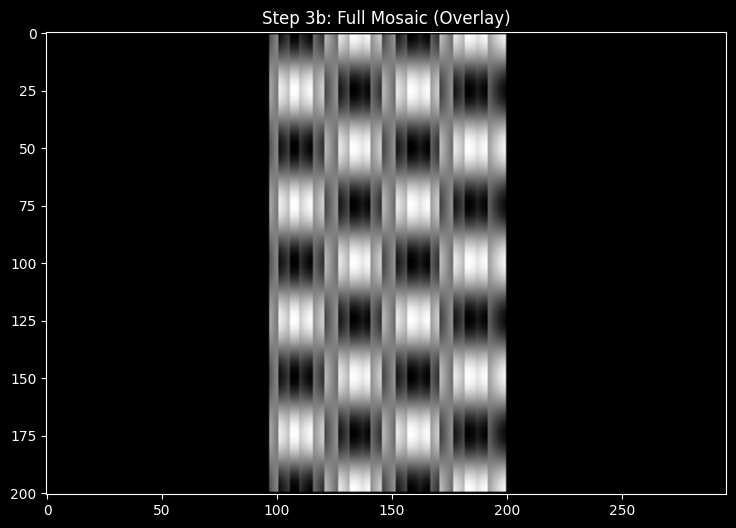

In [49]:
absolute_transforms, (canvas_h, canvas_w), (offset_y,
                                            offset_x) = ex4.find_canvas_limits(
    stabilized_frames, step_size, border_cut)
print("Canvas Size: ", canvas_h, canvas_w)
print("Offsets: ", offset_y, offset_x)
# print("Transforms: ", absolute_transforms)

print("Starting stitching process...")
panorama = ex4.create_mosaic(original_frames, step_size, border_cut)

plt.figure(figsize=(15, 6))
plt.imshow(panorama, cmap='gray')
plt.title("Step 3b: Full Mosaic (Overlay)")
# plt.axis('off') # Hide axes for cleaner view
plt.show()

#### 4. Create mosaic by pasting strips using correct width & location
    a. Start with synthetic videos at constant translation & no rotation...
    b. Back Warping from canvas to frame...


Generating sharp checkerboard frames...
Created 20 frames. Each moves exactly 5 pixels to the right.
Running create_mosaic...
Calculating canvas limits...
Canvas Size: 296x200
Stitching strips with dynamic width...
Stitched 0/20
Stitched 10/20


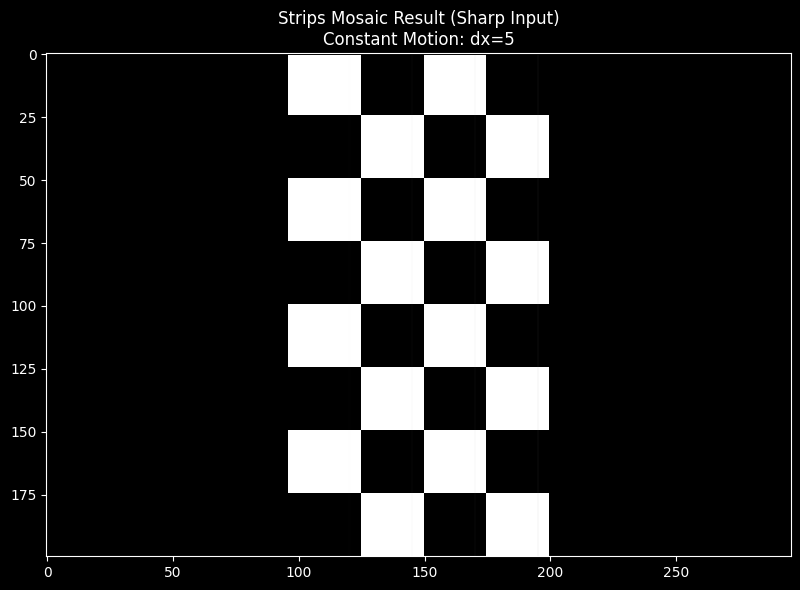

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import ex4

def create_sharp_checkerboard(h, w, block_size=25):
    """
    Creates a sharp 0/1 checkerboard pattern.
    """
    # Create grid of indices
    rows = np.arange(h) // block_size
    cols = np.arange(w) // block_size

    # Checkerboard pattern logic: (row_index + col_index) is even or odd
    # Using broadcasting to create the 2D mask
    board = (rows[:, None] + cols[None, :]) % 2

    return board.astype(np.float64)

# 1. Setup Parameters
H, W = 200, 200    # Frame size
num_frames = 20
dx = 5             # Exact horizontal shift per frame

# Calculate total width needed for the "world"
total_width_needed = W + (num_frames * dx) + 50

print("Generating sharp checkerboard frames...")

# Generate one big wide board first (Ground Truth)
world_map = create_sharp_checkerboard(H, total_width_needed, block_size=25)

frames = []
for i in range(num_frames):
    # Simulate camera panning by slicing the world map directly
    start_x = i * dx
    end_x = start_x + W

    # Extract frame
    current_frame = world_map[:, start_x:end_x]
    frames.append(current_frame)

print(f"Created {len(frames)} frames. Each moves exactly {dx} pixels to the right.")

# 2. Run the Mosaic Stitching
print("Running create_mosaic...")
# Note: border_cut is just passed to alignment, assuming your alignment works well on this
panorama = ex4.create_mosaic(frames, step_size=16, border_cut=15)

# 3. Visualization
plt.figure(figsize=(15, 6))
# Using interpolation='nearest' to see the pixels clearly without smoothing
plt.imshow(panorama, cmap='gray', interpolation='nearest')
plt.title(f"Strips Mosaic Result (Sharp Input)\nConstant Motion: dx={dx}")
plt.tight_layout()
plt.show()

#### 5. Set convergence point (With no setting - this is infinity)
    a. Depth point that does not move between mosaics